# Developing scripts for skill assessment

In [1]:
import cartopy
import cartopy.crs as ccrs

cartopy.config["pre_existing_data_dir"] = "../../data/cartopy-data"
cartopy.config["data_dir"] = "../../data/cartopy-data"

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

from src.verify import verify

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
xr.set_options(keep_attrs=True)

## Load some data to process

In [8]:
config = "../../config/verify/CanESM5.yml"
save_dir = "../../data/skill/"

skill = verify(config, save_dir, save=False)

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


In [9]:
skill[0]

<xarray.Dataset>
Dimensions:  (lead: 10, lat: 90, lon: 144)
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lead     (lead) int64 11 23 35 47 59 71 83 95 107 119
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
    zsurf    (lat, lon) float32 2.83e+03 2.83e+03 2.83e+03 ... 0.0 0.0 0.0
    area     (lat, lon) float32 2.758e+08 2.758e+08 ... 2.758e+08 2.758e+08
    skill    <U11 'initialized'
Data variables:
    sst      (lead, lat, lon) float64 dask.array<chunksize=(1, 45, 72), meta=np.ndarray>
Attributes:
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_initializations:     57
    number_of_members:             40
    alignment:                     same_verifs
    metric:                        pearson_r
    comparison:                    e2o
    dim:                           ['init']
    reference:                     []
    verification period start:     1970-12-01 00:00:00
    verification period end:       2014-12-01 00:00:00

Text(0.5, 1.0, '19701201 - 20171201')

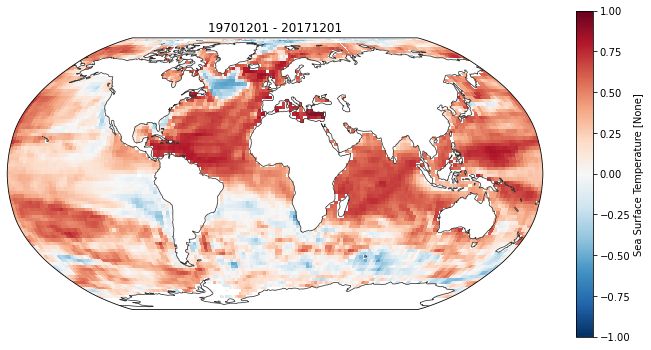

In [33]:
to_plot = skill[0]["sst"]

fig = plt.figure(figsize=(12, 6), edgecolor="k")
ax = fig.add_subplot(111, projection=ccrs.Robinson(0))

p = (
    to_plot.sel(skill="initialized")
    .isel(lead=1)
    .plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap="RdBu_r")
)

p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)
ax.set_title(f"{skill[0].attrs['verification period']}")

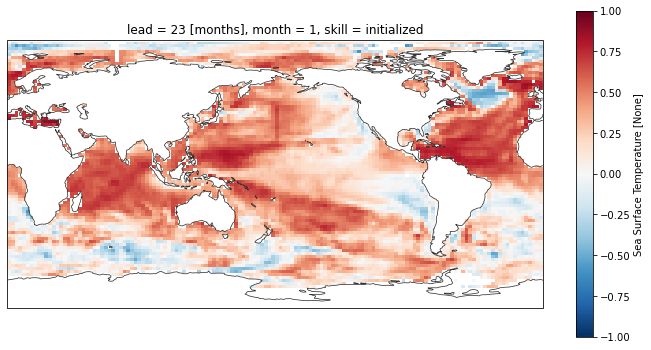

In [17]:
to_plot = skill[0]["sst"]

fig = plt.figure(figsize=(12, 6), edgecolor="k")
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))

p = (
    to_plot.sel(skill="initialized")
    .isel(lead=1)
    .plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap="RdBu_r")
)

p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

In [29]:
a = xr.open_zarr("../../data/processed/CanESM5_hist.annual.anom_1991-2020.sst.zarr")

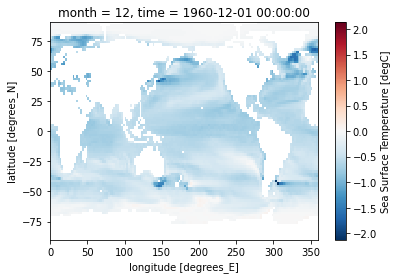

In [31]:
a["sst"].mean("member").isel(time=0).plot()